In [1]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from scipy.stats.mstats import winsorize

In [2]:
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds
print(bbox)

[78.00405826 16.93264351 79.04971836 17.90150706]


In [3]:
import numpy as np
import rasterio

def cloud_mask(cloud_band):
    cloud = (cloud_band >> 3) & 1
    dilated = (cloud_band >> 1) & 1
    return cloud | dilated

def calculate_uhi(tiff_path):
    if os.path.exists(tiff_path):
        with rasterio.open(tiff_path) as src:
            band10 = src.read(1).astype(float)  # LST band
            cloud = src.read(3).astype(int)     # Cloud mask band
            unc = src.read(2).astype(float) * 0.01  # Uncertainty band

            # Apply cloud mask
            mask = cloud_mask(cloud)

           
            LST_K = band10 * 0.00341802 + 149
            LST_C = LST_K - 273.15

            # Apply masking
            lst2 = np.copy(LST_C)
            lst2[(mask == 1)] = np.nan  
            nan_count=np.isnan(lst2).sum()
            if nan_count>= 0.5* lst2.shape[0]*lst2.shape[1]:
                return (np.nan,np.nan)
            
            mean = np.nanmean(lst2)
            sd = np.nanstd(lst2)

            # Initialize UHI array
            uhi = np.zeros(lst2.shape)

            avg_urban = 0
            avg_rural = 0
            urban_count = 0
            rural_count = 0

            # Classify urban and rural pixels
            for i in range(lst2.shape[0]):
                for j in range(lst2.shape[1]):
                    if np.isnan(lst2[i][j]):
                        continue  

                    if lst2[i][j] > mean + 0.5 * sd:
                        uhi[i][j] = 1  # Urban
                        avg_urban += lst2[i][j]
                        urban_count += 1
                    else:
                        uhi[i][j] = -1  # Rural
                        avg_rural += lst2[i][j]
                        rural_count += 1


            if urban_count > 0:
                avg_urban /= urban_count
            else:
                avg_urban = np.nan  

            if rural_count > 0:
                avg_rural /= rural_count
            else:
                avg_rural = np.nan  

            if not np.isnan(avg_urban) and not np.isnan(avg_rural):
                uhi_intensity = avg_urban - avg_rural
                uhi_ratio = uhi_intensity / avg_rural if avg_rural != 0 else np.nan
            else:
                uhi_intensity = np.nan
                uhi_ratio = np.nan

            return (uhi_intensity, uhi_ratio)
    else:
        return (np.nan,np.nan)


In [4]:
months = {
        1: ("January", 31),
        2: ("February", 28),
        3: ("March", 31),
        4: ("April", 30),
        5: ("May", 31),
        6: ("June", 30),
        7: ("July", 31),
        8: ("August", 31),
        9: ("September", 30),
        10: ("October", 31),
        11: ("November", 30),
        12: ("December", 31)
    }

In [195]:
intensities=[]
ratios=[]
years=[]
for year in range(2014,2025):
    for month in months:
            tiff_path=rf"C:\Users\rishi\ml_projects\UHI\Landsat_{year-2000}\Chennai\LST\{months[month][0]}.tif"
            intensity,ratio=calculate_uhi(tiff_path)
            intensities.append(intensity)
            ratios.append(ratio)

In [196]:
ratios

[0.2711658061116463,
 0.24215861679346104,
 0.26842622259945764,
 0.25369171626647186,
 nan,
 0.2803527273223463,
 nan,
 nan,
 0.4879829959649438,
 nan,
 nan,
 0.1407766468827089,
 0.18043222076733678,
 0.19325605887229372,
 0.19889327602682128,
 nan,
 nan,
 0.3567827691378692,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.1766643403520094,
 0.2093463231820175,
 0.22109456471289257,
 nan,
 0.3257724419208943,
 0.5480210465655138,
 nan,
 0.4046246961915215,
 0.75658239157319,
 nan,
 0.19378071343262732,
 0.27533830568141743,
 0.48356489394562574,
 nan,
 nan,
 0.35074385254672164,
 0.2620914813325916,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.6418812096067466,
 0.24405206968292434,
 nan,
 nan,
 nan,
 0.28463981961890594,
 0.3944423413684563,
 nan,
 nan,
 0.3243567564109367,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.26006923397257586,
 0.30929527451960637,
 0.2153108509031551,
 0.23949887899417188,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.26327699618221073,
 0.24334059692314444,
 0.21329660139895626,
 0.18531980125030895

In [220]:
fratios=[]
for i, ele in enumerate(ratios):
    #if i%12 not in np.arange(5,10,1):
        fratios.append(ele)

In [221]:
fratios

[0.2711658061116463,
 0.24215861679346104,
 0.26842622259945764,
 0.25369171626647186,
 nan,
 0.2803527273223463,
 nan,
 nan,
 0.4879829959649438,
 nan,
 nan,
 0.1407766468827089,
 0.18043222076733678,
 0.19325605887229372,
 0.19889327602682128,
 nan,
 nan,
 0.3567827691378692,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.1766643403520094,
 0.2093463231820175,
 0.22109456471289257,
 nan,
 0.3257724419208943,
 0.5480210465655138,
 nan,
 0.4046246961915215,
 0.75658239157319,
 nan,
 0.19378071343262732,
 0.27533830568141743,
 0.48356489394562574,
 nan,
 nan,
 0.35074385254672164,
 0.2620914813325916,
 nan,
 nan,
 nan,
 nan,
 nan,
 1.6418812096067466,
 0.24405206968292434,
 nan,
 nan,
 nan,
 0.28463981961890594,
 0.3944423413684563,
 nan,
 nan,
 0.3243567564109367,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.26006923397257586,
 0.30929527451960637,
 0.2153108509031551,
 0.23949887899417188,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.26327699618221073,
 0.24334059692314444,
 0.21329660139895626,
 0.18531980125030895

In [222]:
len(fratios)
means=[]

In [224]:
m=np.reshape(fratios, (11,12))
print(m)
means=np.nanmedian(m, axis=1)
means

[[0.27116581 0.24215862 0.26842622 0.25369172        nan 0.28035273
         nan        nan 0.487983          nan        nan 0.14077665]
 [0.18043222 0.19325606 0.19889328        nan        nan 0.35678277
         nan        nan        nan        nan        nan 0.17666434]
 [0.20934632 0.22109456        nan 0.32577244 0.54802105        nan
  0.4046247  0.75658239        nan 0.19378071 0.27533831 0.48356489]
 [       nan        nan 0.35074385 0.26209148        nan        nan
         nan        nan        nan 1.64188121 0.24405207        nan]
 [       nan        nan 0.28463982 0.39444234        nan        nan
  0.32435676        nan        nan        nan        nan        nan]
 [0.26006923 0.30929527 0.21531085 0.23949888        nan        nan
         nan        nan        nan        nan 0.263277   0.2433406 ]
 [0.2132966  0.1853198  0.2707566  0.31194558        nan        nan
         nan 1.28442113        nan        nan 0.18441942 0.17494257]
 [0.2389735  0.19244975 0.22129425 0.2400

array([0.26842622, 0.19325606, 0.32577244, 0.30641767, 0.32435676,
       0.25170492, 0.2132966 , 0.23952327, 0.25023545, 0.26249642,
       0.2243239 ])

Text(0.5, 1.0, 'UHI ratio in Hyderabad over 10 Years')

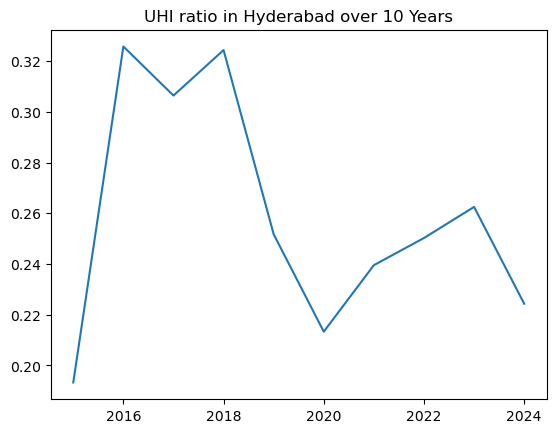

In [225]:
plt.plot(np.arange(2015,2025),means[1:])
plt.title("UHI ratio in Hyderabad over 10 Years")

In [226]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

geo_tiff_path = r'C:\Users\rishi\ml_projects\UHI\Landsat_24\LST\March.tif' 

with rasterio.open(geo_tiff_path) as src:
    band10 = src.read(1).astype(float)
    cloud=src.read(3).astype(int)
    unc=src.read(2).astype(float)*.01 
    st_meta=src.meta
    # Metadata
    transform = src.transform
    extent = [transform[2], transform[2] + transform[0] * src.width,
              transform[5] + transform[4] * src.height, transform[5]]

    LST_K=band10*0.00341802+149
    LST_C=LST_K-273.15
    # fig, ax = plt.subplots(figsize=(10, 10))
    # plt.imshow(LST_C, cmap='rainbow', extent=extent)  
    # plt.title("Land Surface Temperature (LST) - Hyderabad")
    # plt.xlabel("Longitude")
    # plt.ylabel("Latitude")
    # cbar = plt.colorbar()
    # gdf.boundary.plot(ax=ax, edgecolor='black')
    # cbar.set_label("Temperature (°C)")
    # plt.show()

In [227]:
cloud

array([[21824, 21824, 21824, ..., 27362, 27362, 27362],
       [21824, 21824, 21824, ..., 27362, 27362, 27362],
       [21824, 21824, 21824, ..., 27362, 27362, 27362],
       ...,
       [21824, 21824, 21824, ..., 38438, 38438, 38438],
       [21824, 21824, 21824, ..., 38438, 38438, 38438],
       [21824, 21824, 21824, ..., 38438, 38438, 22052]])

In [228]:
bin(38666)

'0b1001011100001010'

In [229]:
LST_C

array([[39.95939426, 37.84363988, 33.37799675, ..., 32.61520862,
        32.62660202, 32.08427618],
       [40.20207368, 38.35634288, 33.47882834, ..., 32.97125237,
        33.19057532, 33.11936657],
       [40.87542362, 39.93034109, 35.57749262, ..., 32.54798756,
        32.62261433, 31.72652342],
       ...,
       [42.54341738, 43.02194018, 44.27806253, ..., 19.18295969,
        18.91293611, 25.56269402],
       [43.77219557, 43.91746142, 43.68161804, ..., 25.87544285,
        24.6705908 , 27.61863305],
       [43.68161804, 44.00120291, 43.93626053, ..., 29.52588821,
        27.71946464, 27.84080435]])

In [230]:
too_high=0
nan_count=0
lst2=LST_C
for i in range(len(unc)):
    for j in range(len(unc[0])):
        if unc[i][j]>=10:
            lst2[i][j]=np.nan
            nan_count+=1
        if LST_C[i][j]>=55:
            too_high+=1

In [231]:
too_high

15

In [232]:
nan_count

5

In [233]:
lst2.shape

(1080, 1165)

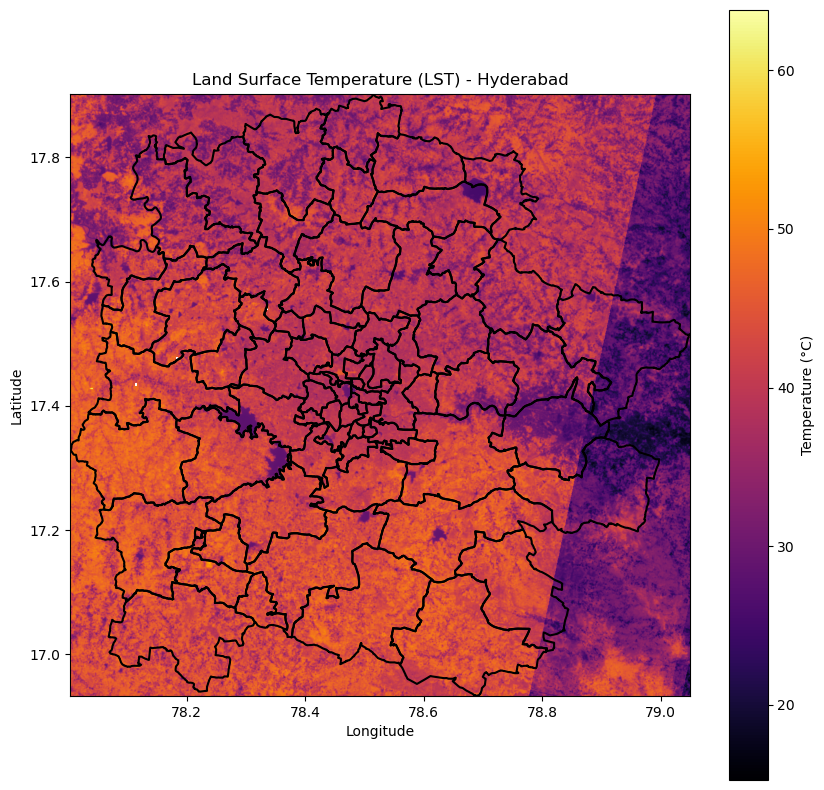

In [234]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(lst2, cmap='inferno', extent=extent)  
plt.title("Land Surface Temperature (LST) - Hyderabad")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
gdf.boundary.plot(ax=ax, edgecolor='black')
cbar.set_label("Temperature (°C)")
plt.show()

## UHI Calculation

In [235]:
mean=np.nanmean(lst2)
sd=np.nanstd(lst2)

In [236]:
print(f"Mean : {mean}     Standard Deviation : {sd}")

Mean : 38.97130749385259     Standard Deviation : 6.218269200810233


In [237]:
uhi=np.zeros((len(lst2),len(lst2[0])))
uhi.shape
avg_urban=0
avg_rural=0
urban_count=0
rural_count=0
for i in range (len(lst2)):
    for j in range(len(lst2[0])):
        if lst2[i][j]> mean + 0.5*sd:
            uhi[i][j]=1
            avg_urban+=lst2[i][j]
            urban_count+=1
        elif lst2[i][j]<= mean + 0.5*sd:
            uhi[i][j]=-1
            avg_rural+=lst2[i][j]
            rural_count+=1
avg_rural=avg_rural/rural_count
avg_urban=avg_urban/urban_count

In [238]:
avg_rural

35.75661710647445

In [239]:
avg_urban

44.90358611296031

In [240]:
uhi_intensity=avg_urban -avg_rural
uhi_intensity

9.146969006485861

In [241]:
uhi_intensity/avg_rural

0.2558119236852979

In [242]:
uhi

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

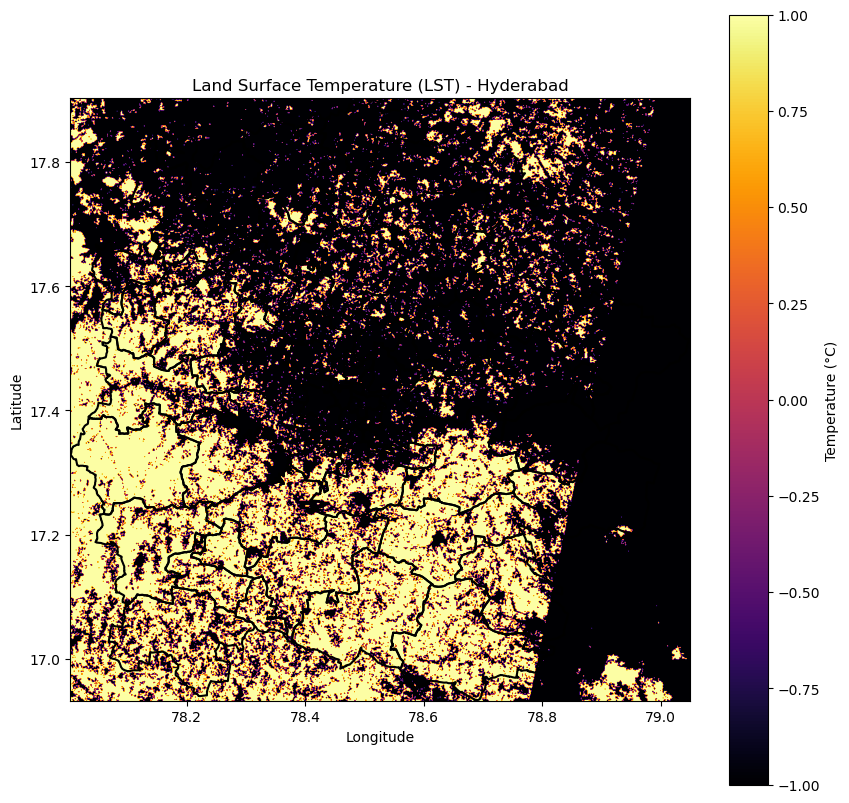

In [243]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(uhi, cmap='inferno', extent=extent)  
plt.title("Land Surface Temperature (LST) - Hyderabad")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
gdf.boundary.plot(ax=ax, edgecolor='black')
cbar.set_label("Temperature (°C)")
plt.show()
